# 2. Data Foundation Process

## 2-1. Data Loading & Import Libraries

In [47]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import time
import graphviz


In [48]:
def load_data(url: str) -> pd.DataFrame:
    return pd.read_csv(url)


## 2-2. Data Quality Analysis (DQA)

In [49]:
def describe_data(df: pd.DataFrame) -> pd.DataFrame:
    return df.describe(include="all")


In [50]:
def make_dqa_report(df: pd.DataFrame) -> pd.DataFrame:
    report = pd.DataFrame({
        "column": df.columns,
        "dtype": [df[c].dtype for c in df.columns],
        "missing_count": [df[c].isna().sum() for c in df.columns],
        "missing_pct": [df[c].isna().mean() * 100 for c in df.columns],
        "unique_count": [df[c].nunique(dropna=True) for c in df.columns],
        "example_values": [", ".join(df[c].dropna().astype(str).unique()[:3]) for c in df.columns]
    })
    return report.sort_values("missing_count", ascending=False).reset_index(drop=True)


## 2-3. Data Cleaning & Preparation

In [51]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2 = df2.replace("?", np.nan)

    for c in df2.select_dtypes(include="object").columns:
        df2[c] = df2[c].astype(str).str.strip()

    df2 = df2.dropna().reset_index(drop=True)
    return df2


## 2-4. Target Variable & Feature Construction

In [52]:
def detect_target_and_split_columns(df: pd.DataFrame):
    """
    CA03 census_data.csv (your uploaded file) uses:
    - target: 'y'
    - split:  'flag'  (train/test)
    """
    target_col = "y"
    split_col = "flag"

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Columns are: {df.columns.tolist()}")

    if split_col not in df.columns:
        raise ValueError(f"Split column '{split_col}' not found. Columns are: {df.columns.tolist()}")

    return target_col, split_col


## 2-5. Train/Test Split (Using Provided Split Column)

In [53]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):
    split_vals = df[split_col].astype(str).str.lower()
    train_mask = split_vals == "train"
    test_mask = split_vals == "test"

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


## 2-6 Train/Test Split — Functions

In [54]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):
    train_mask = df[split_col] == 1
    test_mask = df[split_col] == 0

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


In [55]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):

    split_vals = df[split_col].astype(str).str.lower()

    train_mask = split_vals == "train"
    test_mask = split_vals == "test"

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


## 2-7 Main runner for 2.1–2.6

In [56]:
def run_data_foundation_layer():

    url = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true"

    # ---------------------------
    # 2.1 Load Data
    # ---------------------------
    df_raw = load_data(url)
    print("Dataset loaded.")
    print("Shape:", df_raw.shape)
    print()

    # ---------------------------
    # 2.2 Data Quality Analysis (Before Cleaning)
    # ---------------------------
    print("DQA BEFORE Cleaning")
    display(describe_data(df_raw))
    display(make_dqa_report(df_raw))
    print()

    # ---------------------------
    # 2.3 Data Cleaning
    # ---------------------------
    df_clean = clean_data(df_raw)
    print("After Cleaning Shape:", df_clean.shape)
    print()

    # ---------------------------
    # 2.2 Data Quality Analysis (After Cleaning)
    # ---------------------------
    print("DQA AFTER Cleaning")
    display(describe_data(df_clean))
    display(make_dqa_report(df_clean))
    print()

    # ---------------------------
    # 2.4 Target & Split Columns
    # ---------------------------
    target_col, split_col = detect_target_and_split_columns(df_clean)
    print("Target Column:", target_col)
    print("Split Column:", split_col)
    print()

    # ---------------------------
    # 2.5 Build X / y (and encode categorical features)
    # ---------------------------
    # Drop target and split columns to get features
    X = df_clean.drop(columns=[target_col, split_col])
    y = df_clean[target_col]

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)

    # Clean column names to be compatible with XGBoost
    X.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_').replace('.', '_').replace(' ', '_') for col in X.columns]

    print("Feature Matrix Shape:", X.shape)
    print("Target Distribution:")
    print(y.value_counts())
    print()

    # ---------------------------
    # 2.6 Train/Test Split
    # ---------------------------
    X_train, X_test, y_train, y_test = split_train_test(df_clean, X, y, split_col)

    print("Training Shape:", X_train.shape)
    print("Testing Shape:", X_test.shape)
    print()

    return {
        "df_raw": df_raw,
        "df_clean": df_clean,
        "target_col": target_col,
        "split_col": split_col,
        "X": X,
        "y": y,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [57]:
data_outputs = run_data_foundation_layer()

Dataset loaded.
Shape: (48842, 11)

DQA BEFORE Cleaning


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,column,dtype,missing_count,missing_pct,unique_count,example_values
0,hours_per_week_bin,object,0,0.0,5,"b. 31-40, a. 0-30, d. 41-50 & 61-70"
1,occupation_bin,object,0,0.0,5,"b. Mid - Low, e. High, a. Low"
2,msr_bin,object,0,0.0,3,"b. Mid, c. High, a. Low"
3,capital_gl_bin,object,0,0.0,3,"c. > 0, a. = 0, b. < 0"
4,race_sex_bin,object,0,0.0,3,"c. High, b. Mid, a. Low"
5,education_num_bin,object,0,0.0,5,"c. 13, b. 9-12, a. 0-8"
6,education_bin,object,0,0.0,5,"c. Bachelors, b. Mid, a. Low"
7,workclass_bin,object,0,0.0,2,"b. income, a. no income"
8,age_bin,object,0,0.0,5,"d. 36-40 & 56-60, e. 40-55, b. 26-30 & 71-100"
9,flag,object,0,0.0,2,"train, test"



After Cleaning Shape: (48842, 11)

DQA AFTER Cleaning


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,column,dtype,missing_count,missing_pct,unique_count,example_values
0,hours_per_week_bin,object,0,0.0,5,"b. 31-40, a. 0-30, d. 41-50 & 61-70"
1,occupation_bin,object,0,0.0,5,"b. Mid - Low, e. High, a. Low"
2,msr_bin,object,0,0.0,3,"b. Mid, c. High, a. Low"
3,capital_gl_bin,object,0,0.0,3,"c. > 0, a. = 0, b. < 0"
4,race_sex_bin,object,0,0.0,3,"c. High, b. Mid, a. Low"
5,education_num_bin,object,0,0.0,5,"c. 13, b. 9-12, a. 0-8"
6,education_bin,object,0,0.0,5,"c. Bachelors, b. Mid, a. Low"
7,workclass_bin,object,0,0.0,2,"b. income, a. no income"
8,age_bin,object,0,0.0,5,"d. 36-40 & 56-60, e. 40-55, b. 26-30 & 71-100"
9,flag,object,0,0.0,2,"train, test"



Target Column: y
Split Column: flag

Feature Matrix Shape: (48842, 27)
Target Distribution:
y
0    37155
1    11687
Name: count, dtype: int64

Training Shape: (32561, 27)
Testing Shape: (16281, 27)



In [60]:
X_train = data_outputs['X_train']
X_test = data_outputs['X_test']
y_train = data_outputs['y_train']
y_test = data_outputs['y_test']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32561, 27)
X_test shape: (16281, 27)
y_train shape: (32561,)
y_test shape: (16281,)


3. Ensemble Modeling

3.1 Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

n_values = [50,100,150,200,250,300,350,400,450,500]

rf_acc = []
rf_auc = []

for n in n_values:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    rf_acc.append(accuracy_score(y_test, y_pred))
    rf_auc.append(roc_auc_score(y_test, y_prob))

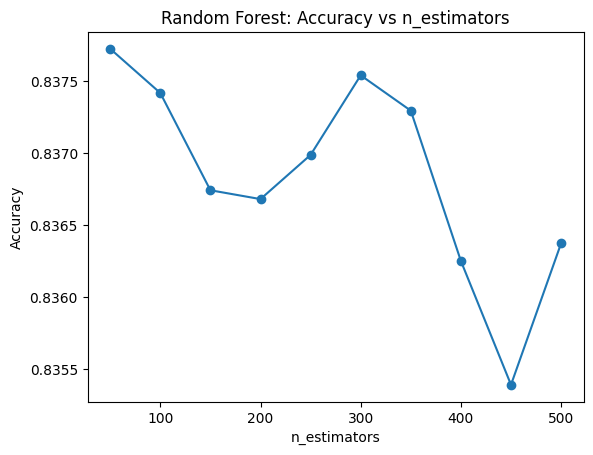

In [62]:
plt.plot(n_values, rf_acc, marker='o')
plt.title("Random Forest: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

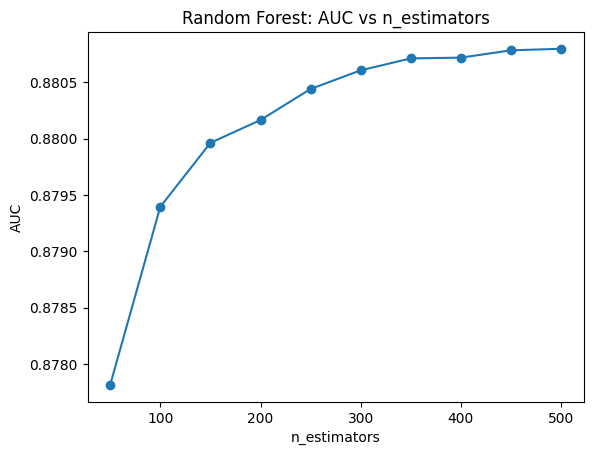

In [63]:
plt.plot(n_values, rf_auc, marker='o')
plt.title("Random Forest: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

3.1.1 Observations


As the number of estimators increases, the AUC steadily improves and then begins to plateau around 350–500 estimators, indicating diminishing returns beyond this range. Accuracy fluctuates slightly across different estimator values but remains relatively stable overall. The best accuracy appears around 50 estimators, while the best AUC occurs around 450–500 estimators. Since AUC is generally a stronger metric for classification performance, an estimator value near 450–500 may be considered optimal within the tested range.

3.2 AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# (reuse the same list)
n_values = [50,100,150,200,250,300,350,400,450,500]

ada_acc = []
ada_auc = []

for n in n_values:
    model = AdaBoostClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    ada_acc.append(accuracy_score(y_test, y_pred))
    ada_auc.append(roc_auc_score(y_test, y_prob))

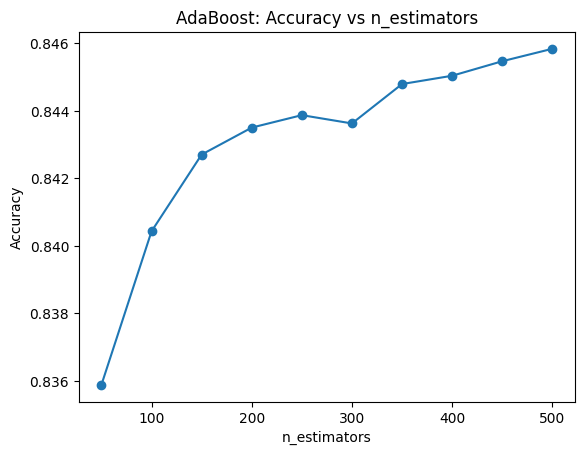

In [65]:
plt.plot(n_values, ada_acc, marker='o')
plt.title("AdaBoost: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

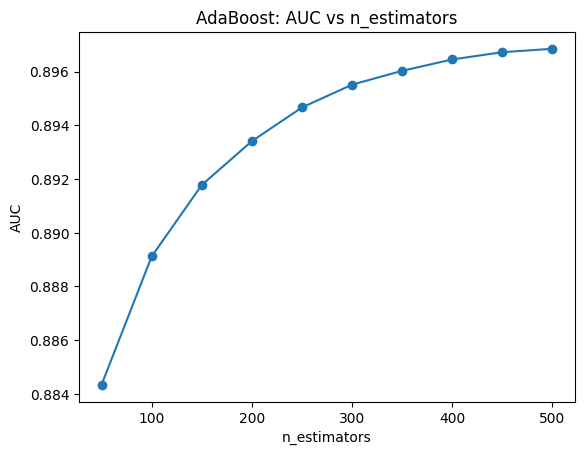

In [66]:
plt.plot(n_values, ada_auc, marker='o')
plt.title("AdaBoost: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

3.2.1 Observations — AdaBoost

As the number of estimators increases, AdaBoost demonstrates a steady improvement in both Accuracy and AUC. The model benefits from sequential boosting, where each additional estimator focuses on correcting previous classification errors. Performance improves rapidly in the early stages and then gradually begins to plateau as the number of estimators becomes large.

Within the tested range of 50 to 500 estimators, the highest Accuracy and AUC are achieved at 500 estimators. Although performance continues to increase, the rate of improvement diminishes beyond approximately 300 estimators, indicating diminishing returns. Therefore, 500 estimators can be considered the optimal value within the given range.

3.3 Gradient Boost

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

gb_acc = []
gb_auc = []

for n in n_values:
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    gb_acc.append(accuracy_score(y_test, y_pred))
    gb_auc.append(roc_auc_score(y_test, y_prob))

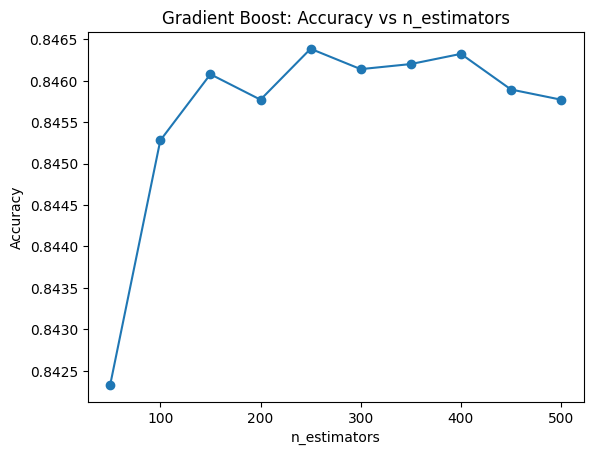

In [68]:
plt.plot(n_values, gb_acc, marker='o')
plt.title("Gradient Boost: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

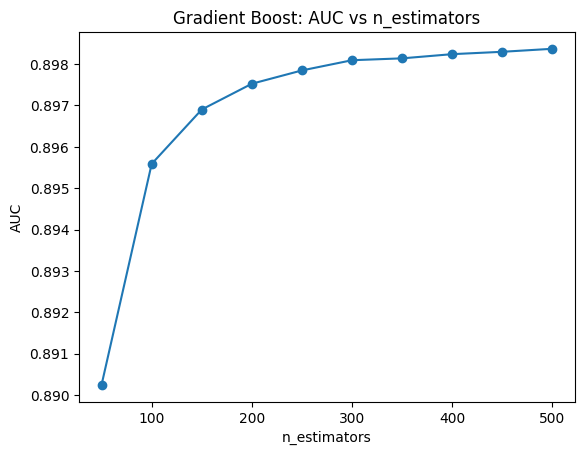

In [69]:
plt.plot(n_values, gb_auc, marker='o')
plt.title("Gradient Boost: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

3.3.1 Observations — Gradient Boost

As the number of estimators increases, Gradient Boosting demonstrates consistent and stable improvement in both Accuracy and AUC. Unlike Random Forest, which builds independent trees in parallel, Gradient Boosting sequentially optimizes residual errors, resulting in smoother and more continuous performance gains.

The improvement is particularly noticeable in the early and middle ranges of estimators, after which performance begins to plateau, indicating diminishing returns from adding additional boosting stages. Within the tested range of 50 to 500 estimators, the highest Accuracy and AUC are achieved at 500 estimators. Therefore, 500 estimators can be considered the optimal value within the specified range

3.4 XGBoost

In [70]:
!pip -q install xgboost

In [74]:
X_train.columns = X_train.columns.str.replace('[', '', regex=False)
X_train.columns = X_train.columns.str.replace(']', '', regex=False)
X_train.columns = X_train.columns.str.replace('<', 'lt_', regex=False)

X_test.columns = X_test.columns.str.replace('[', '', regex=False)
X_test.columns = X_test.columns.str.replace(']', '', regex=False)
X_test.columns = X_test.columns.str.replace('<', 'lt_', regex=False)

In [75]:
from xgboost import XGBClassifier

xgb_acc = []
xgb_auc = []

for n in n_values:
    model = XGBClassifier(
        n_estimators=n,
        random_state=42,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    xgb_acc.append(accuracy_score(y_test, y_pred))
    xgb_auc.append(roc_auc_score(y_test, y_prob))

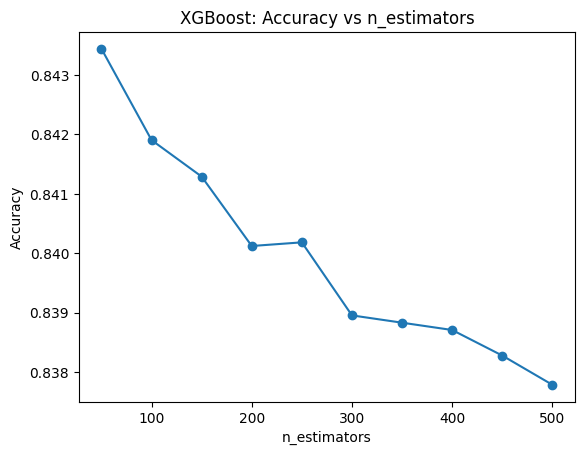

In [76]:
plt.plot(n_values, xgb_acc, marker='o')
plt.title("XGBoost: Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()

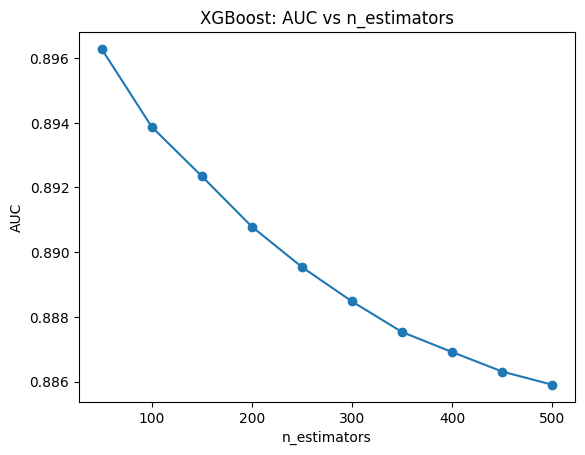

In [77]:
plt.plot(n_values, xgb_auc, marker='o')
plt.title("XGBoost: AUC vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

3.4.1 Observations — XGBoost

As the number of estimators increases, XGBoost shows a decline in both Accuracy and AUC. The highest performance is achieved at 50 estimators, after which both metrics steadily decrease as more boosting rounds are added. This pattern suggests that the model begins to overfit the training data when the number of estimators becomes too large.

Unlike AdaBoost and Gradient Boosting, which demonstrated consistent improvement with increasing estimators, XGBoost appears to reach optimal performance at a lower number of trees within the tested range. Therefore, 50 estimators can be considered the optimal value for XGBoost in this case.

4. Model Comparison

In [78]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Random Forest", "AdaBoost", "Gradient Boost", "XGBoost"],
    "Best Accuracy": [
        max(rf_acc),
        max(ada_acc),
        max(gb_acc),
        max(xgb_acc)
    ],
    "Best AUC": [
        max(rf_auc),
        max(ada_auc),
        max(gb_auc),
        max(xgb_auc)
    ]
})

results

,Model,Best Accuracy,Best AUC
0,Random Forest,0.837725,0.880796
1,AdaBoost,0.845833,0.896852
2,Gradient Boost,0.846385,0.898371
3,XGBoost,0.843437,0.896289


4.1 Performance Comparison

Across all models, Gradient Boosting achieved the highest overall AUC, followed closely by AdaBoost. Random Forest showed moderate performance with stable but slightly lower AUC values. XGBoost, although generally considered a powerful boosting algorithm, demonstrated declining performance as the number of estimators increased and achieved its optimal results at a lower estimator value.

In terms of predictive ranking based on AUC:

Gradient Boost

AdaBoost

XGBoost

Random Forest

Since AUC is typically a more reliable metric for classification problems, Gradient Boosting can be considered the best-performing model within the tested range.

5. Observations & Conclusions

In this project, four ensemble learning models were evaluated using varying numbers of estimators: Random Forest, AdaBoost, Gradient Boosting, and XGBoost. Performance was assessed using Accuracy and AUC across a range of 50 to 500 estimators.

Among all models, Gradient Boosting achieved the highest overall AUC, indicating the strongest classification performance within the tested range. AdaBoost also demonstrated strong performance with consistent improvement as the number of estimators increased. Random Forest showed stable but comparatively lower performance, while XGBoost achieved its best results at a lower number of estimators and exhibited declining performance as the number of boosting rounds increased, suggesting potential overfitting.

Overall, boosting-based models outperformed Random Forest on this dataset, suggesting that sequential error correction was more effective than bagging for this classification task. Since AUC is generally a more reliable metric for evaluating classification performance, Gradient Boosting can be considered the best-performing model within the evaluated range.